# Analysis of first image of CTIO data 2016
===============================================================


- Author : Sylvie Dagoret-Campagne

- It shows an image.
- it open ds9 on that image

I use this analysis

https://github.com/sylvielsstfr/MonoCamMay2016/blob/master/MyReduction_2016_05_11/ExtractSpectrum_From_HD158485_grat.ipynb

### Defines packages
======================

##### ccdproc
-------

http://ccdproc.readthedocs.io/en/latest/ccdproc/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits

import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [2]:
from scipy import stats  
from scipy import ndimage
import os
from datetime import datetime, timedelta

In [3]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


##### photutils
------------
https://photutils.readthedocs.io/en/latest/

In [4]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [5]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [6]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2017-01-11 15:59:15.148560
fits date format for the analysis :  2017-01-11T15:59:15


### defines the input file
=========================

In [7]:
path_img='/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOData2016'
file_img='fileno016.fits'
object_name='fileno016'

In [8]:
fullfile=os.path.join(path_img,file_img)

### Open input file
===================

In [9]:
prim_hdr=fits.getheader(fullfile) # 

In [10]:
#exposure = prim_hdr['EXPOSURE']
date_obs = prim_hdr['DATE-OBS']

In [11]:
print date_obs
#print 'exposure = ',exposure,'seconds'

2016-08-23T02:55:43.922


In [12]:
hdu_list=fits.open(fullfile)
hdu_list.info()

Filename: /Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOData2016/fileno016.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     135   (2168, 2048)   int16 (rescales to uint16)   


In [13]:
header=hdu_list[0].header
#header

### extract the image
=======================

In [14]:
image_data = hdu_list[0].data

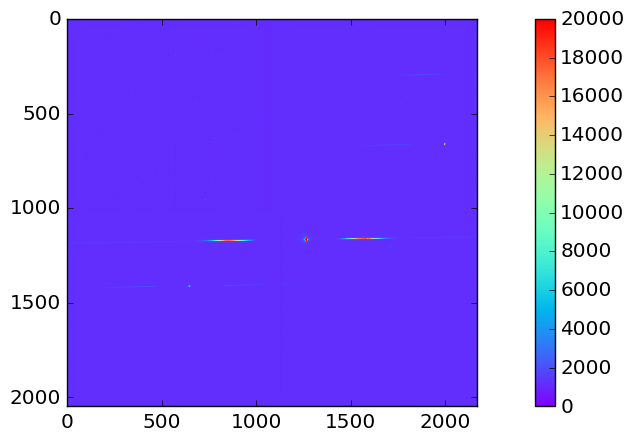

In [15]:
im=plt.imshow(image_data,cmap='rainbow',vmin=0,vmax=20000)
plt.colorbar(im)

In [16]:
mean, median, std = sigma_clipped_stats(image_data, sigma=3.0, iters=5)
print((mean, median, std))    

(1203.1688877738584, 1207.0, 19.278419619125394)


### View in DS9
================

In [17]:
import pyds9
import os


An instance of ds9 was found to be running before we could
start the 'xpans' name server. You will need to perform a
bit of manual intervention in order to connect this
existing ds9 to Python.

For ds9 version 5.7 and beyond, simply register the
existing ds9 with the xpans name server by selecting the
ds9 File->XPA->Connect menu option. Your ds9 will now be
fully accessible to pyds9 (e.g., it appear in the list
returned by the ds9_targets() routine).

For ds9 versions prior to 5.7, you cannot (easily) register
with xpans, but you can view ds9's File->XPA Information
menu option and pass the value associated with XPA_METHOD
directly to the Python DS9() constructor, e.g.:

    d = DS9('a000101:12345')

The good news is that new instances of ds9 will be
registered with xpans, and will be known to ds9_targets()
and the DS9() constructor.



In [18]:
print(pyds9.ds9_targets())

None


In [19]:
d = pyds9.DS9()

In [20]:
# define the zoom
ds9command='zoom 0.125'
d.set(ds9command)
# set the scale
ds9command='scale histequ zscale'
d.set(ds9command)

#ds9command='frame '+ str(channel)
#d.set(ds9command)    
# set the scale
#ds9command='scale histequ'
#d.set(ds9command)
#ds9command='scale zscale'
#d.set(ds9command)
# set the color
#ds9command='cmap rainbow'
#d.set(ds9command)
## define the image
#filelist=fullfilepath+'['+str(channel) + ']' 
ds9command = 'file '+ fullfile
d.set(ds9command)  # send the file to the open ds9 session


1

### Min and Max of the image
==============================

In [21]:
print(type(image_data))
print('image shape',image_data.shape)
themin=image_data.min()
themax=image_data.max()
print('min and max',themin,themax)

<type 'numpy.ndarray'>
('image shape', (2048, 2168))
('min and max', 771, 62969)


### Histogram of image values
================================

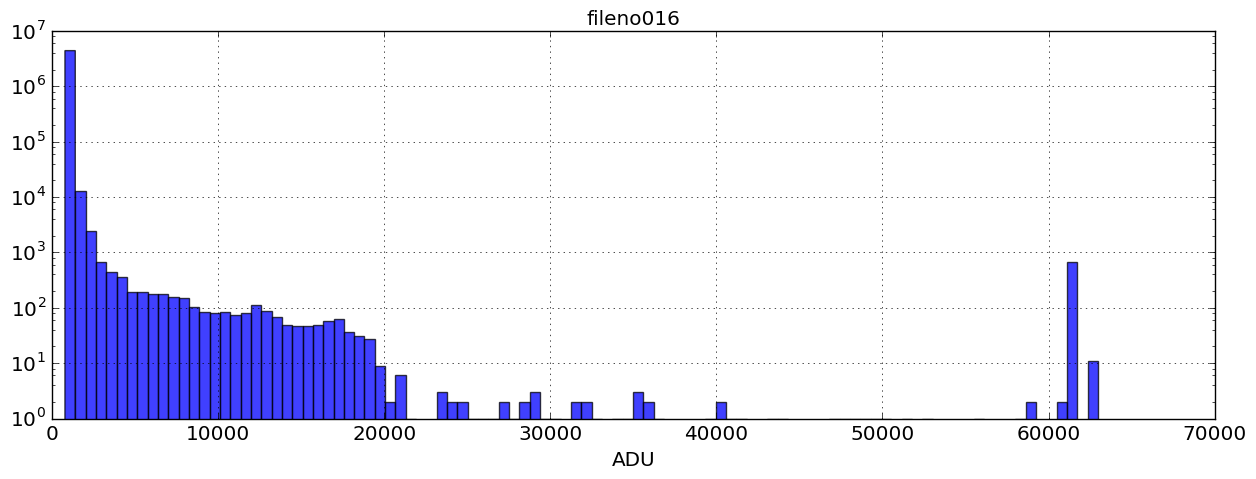

In [22]:
title=object_name
fig = plt.figure()
ax = fig.add_subplot(111)
image_data_flat=image_data.flatten()
plt.hist(image_data_flat,bins=100,facecolor='blue', alpha=0.75);
ax.set_title(title)
ax.set_xlabel('ADU')
ax.grid(True)
plt.yscale('log')
plt.show()

### Transfer the image in CCDData
====================================

In [23]:
ccd=ccdproc.CCDData.read(fullfile, hdu=0,unit="adu") 

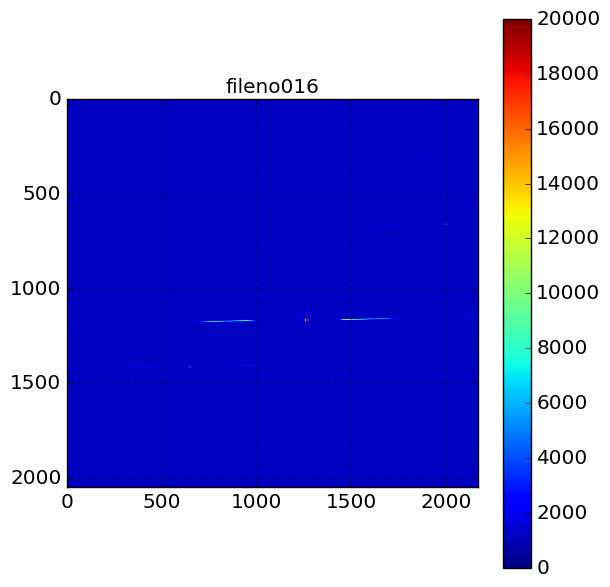

In [24]:
ig, ax = plt.subplots(figsize=(6,6))
img=ax.imshow(ccd,vmin=0,vmax=20000.)
plt.title(object_name)
plt.tight_layout()
plt.colorbar(img)
plt.grid(True)
plt.savefig(object_name)

### Extraction of Background
===============================

In [25]:
sigma_clip = SigmaClip(sigma=3., iters=10)

In [26]:
bkg_estimator = MedianBackground()

In [27]:
bkg = Background2D(ccd, (70, 70), filter_size=(3, 3),method='median')
#bkg = Background2D(ccd.data, (50, 50), filter_size=(3, 3),sigma_clip=sigma_clip,bkg_estimator=bkg_estimator)

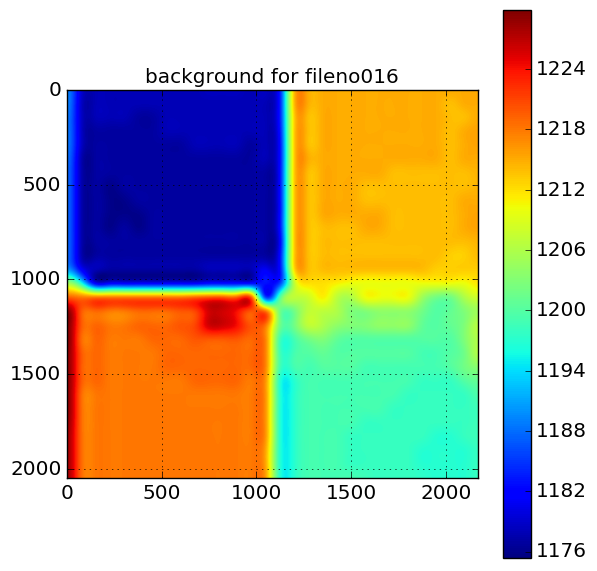

In [28]:
fig, ax = plt.subplots(figsize=(6,6))
img=ax.imshow(bkg.background)
title = 'background for '+ object_name
plt.title(title)
plt.tight_layout()
plt.colorbar(img)
plt.grid(True)

#plt.savefig()

#### Structure of the background
==================================

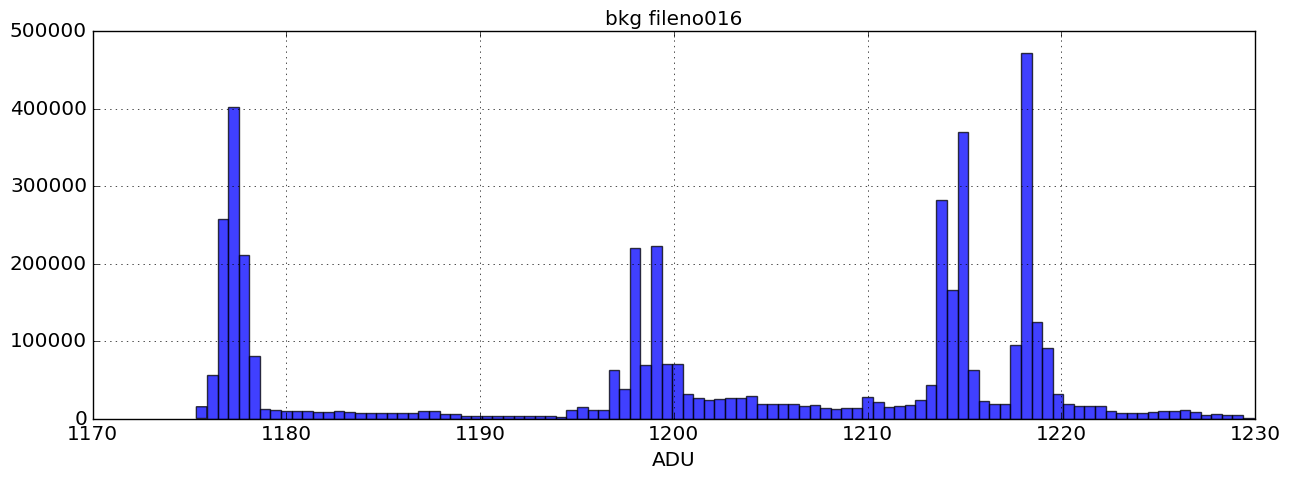

In [29]:
title='bkg '+object_name
fig = plt.figure()
ax = fig.add_subplot(111)
bkg_data=bkg.background
bkg_flat=bkg_data.flatten()
plt.hist(bkg_flat,bins=100,facecolor='blue', alpha=0.75);
ax.set_title(title)
ax.set_xlabel('ADU')
ax.grid(True)
#plt.yscale('log')
plt.show()

In [30]:
print('median background = ',bkg.background_median)
print('median rms = ',bkg.background_rms_median)

('median background = ', 1206.0)
('median rms = ', 6.1257199649166232)


### Image subtracted from background
========================================

In [31]:
ccd_bgsub=ccd - bkg.background

#### histogram of corrected image
------------------------------

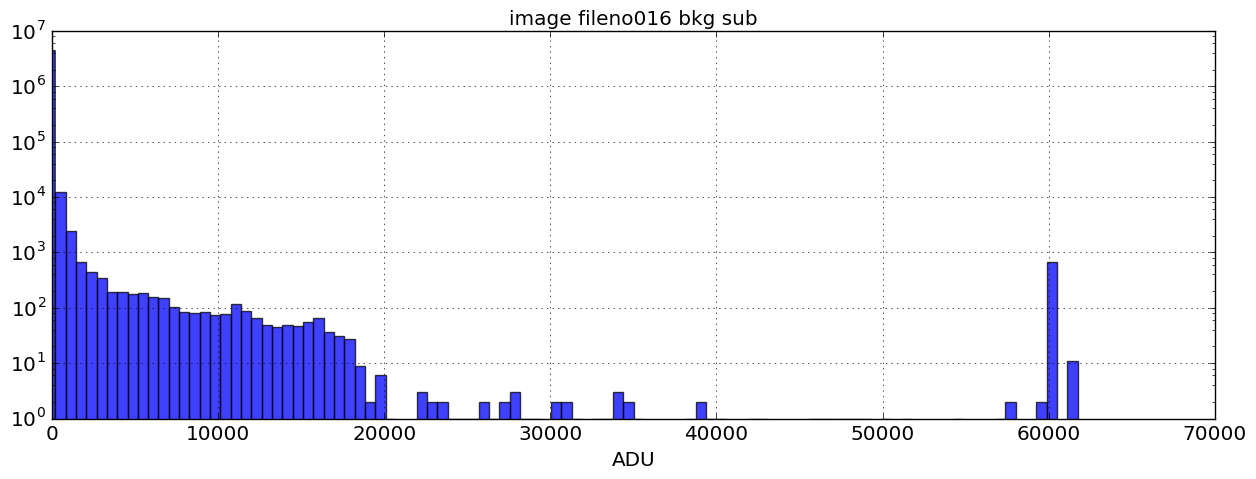

In [32]:
title='image '+object_name+' bkg sub'
fig = plt.figure()
ax = fig.add_subplot(111)
ccd_bgsub_flat=ccd_bgsub.flatten()
plt.hist(ccd_bgsub_flat,bins=100,facecolor='blue', alpha=0.75);
ax.set_title(title)
ax.set_xlabel('ADU')
ax.grid(True)
plt.yscale('log')
plt.xlim(-1,70000.)
plt.show()

#### image of corrected image
----

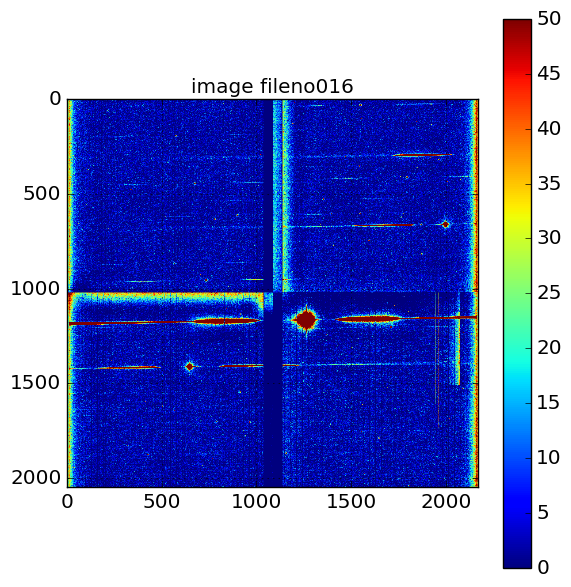

In [33]:
title='image '+object_name
fig, ax = plt.subplots(figsize=(6, 6))
img=ax.imshow(ccd_bgsub,vmin=0,vmax=50.)
plt.title(title)
plt.tight_layout()
plt.colorbar(img)
plt.grid(True)
#plt.savefig('imagebgsub')

### Rotation of the image
==========================

In [34]:
rotated_image=ndimage.interpolation.rotate(ccd_bgsub,-1)

#### rotated image
-----------------

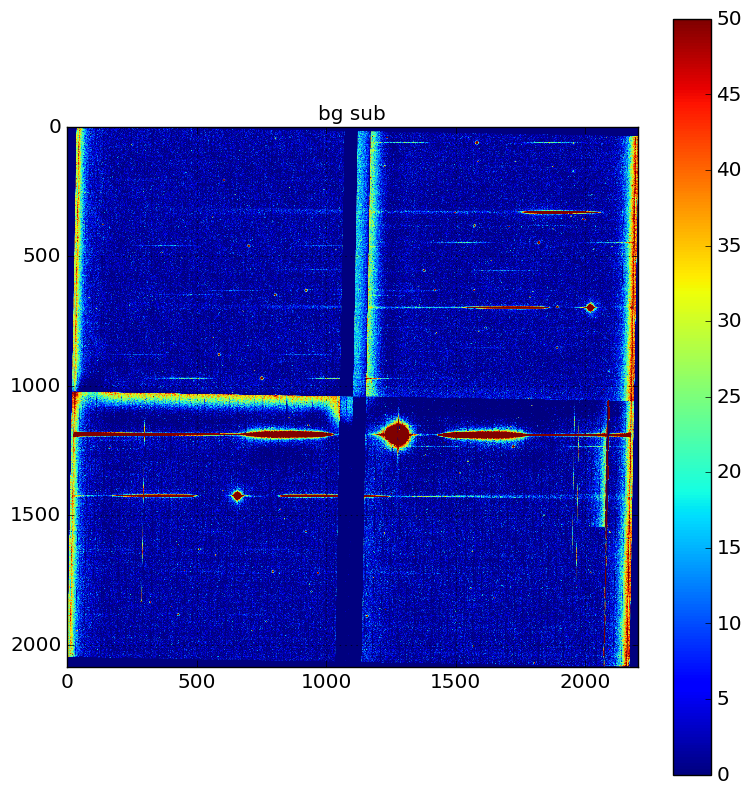

In [35]:
fig, ax = plt.subplots(figsize=(8,8))
img=ax.imshow(rotated_image,vmin=0,vmax=50.)
plt.title('bg sub')
plt.tight_layout()
plt.colorbar(img)
plt.grid(True)
plt.savefig('imagerot')

In [36]:
themaximum=rotated_image.max()

In [37]:
imax,jmax = np.unravel_index(rotated_image.argmax(),rotated_image.shape)
print imax,' ',jmax

1210   1275


In [38]:
rotated_image.shape

(2086, 2203)

In [39]:
max_index_y=rotated_image.shape[0]-1
max_index_x=rotated_image.shape[1]-1

### Extraction of spectra region
=================================

In [40]:
imax=1190
w=10

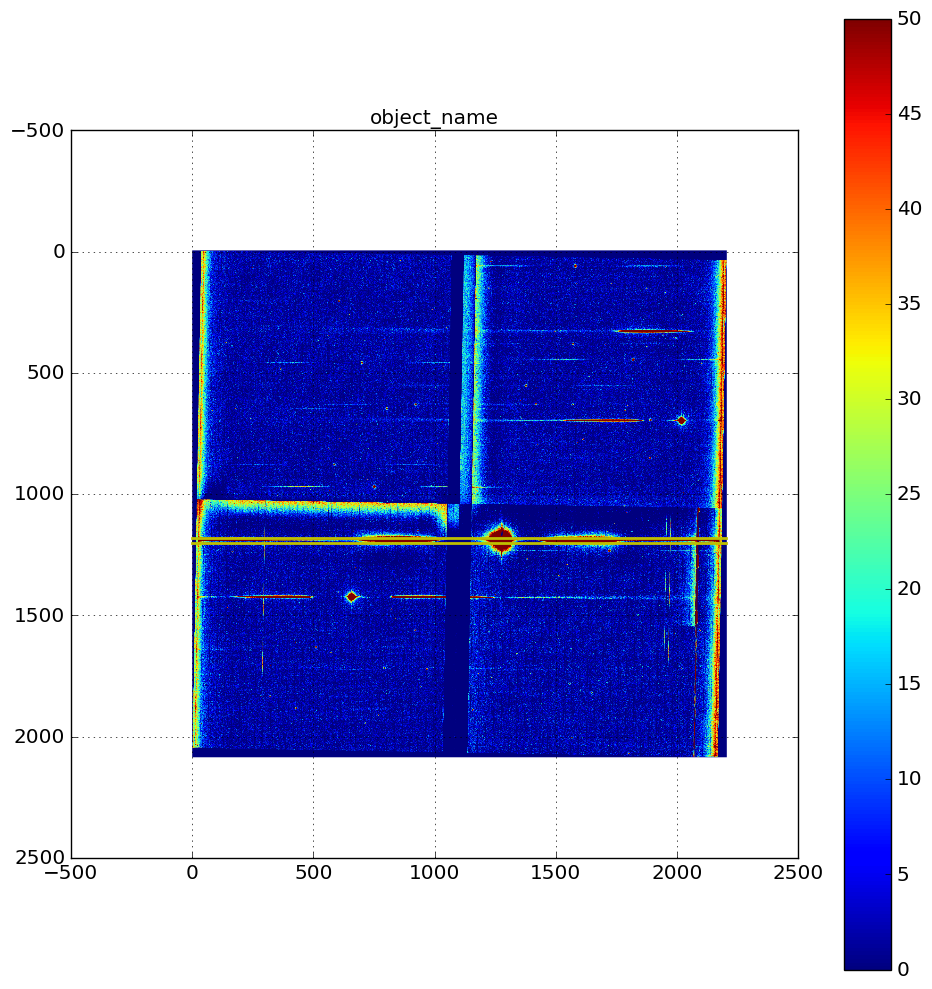

In [41]:
# check the central region is OK
# -------------------------------
fig, ax = plt.subplots(figsize=(10,10))
img=ax.imshow(rotated_image,vmin=0,vmax=50.)
plt.colorbar(img)
ax.plot([0, max_index_x], [imax-w, imax-w], color='y', linestyle='-', linewidth=2)
ax.plot([0,max_index_x], [imax+w, imax+w], color='y', linestyle='-', linewidth=2)
plt.title('object_name')
plt.tight_layout()
plt.grid(True)
#plt.savefig(outputfigfilename4)

#### Profiles of three vertical slices
-------------------------------

In [42]:
profile1=np.sum(rotated_image[:,700:1000],axis=1)  # left wing profile
profile2=np.sum(rotated_image[:,1200:1300],axis=1) # central star profile
profile3=np.sum(rotated_image[:,1300:1800],axis=1) # right wing profile 

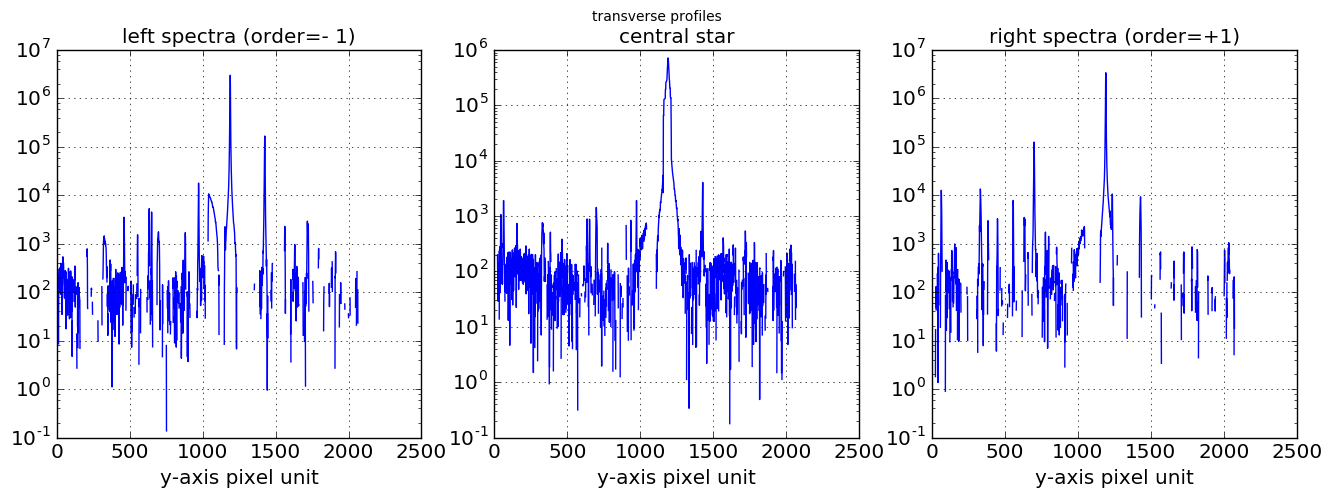

In [43]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16.,5))
ax1.semilogy(profile1)
ax2.semilogy(profile2)
ax3.semilogy(profile3)
#ax1.plot(profile1)
#ax2.plot(profile2)
#ax3.plot(profile3)
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)

ax1.set_title('left spectra (order=- 1)')
ax2.set_title('central star')
ax3.set_title('right spectra (order=+1)')
ax1.set_xlabel('y-axis pixel unit')
ax2.set_xlabel('y-axis pixel unit')
ax3.set_xlabel('y-axis pixel unit')
plt.suptitle('transverse profiles')

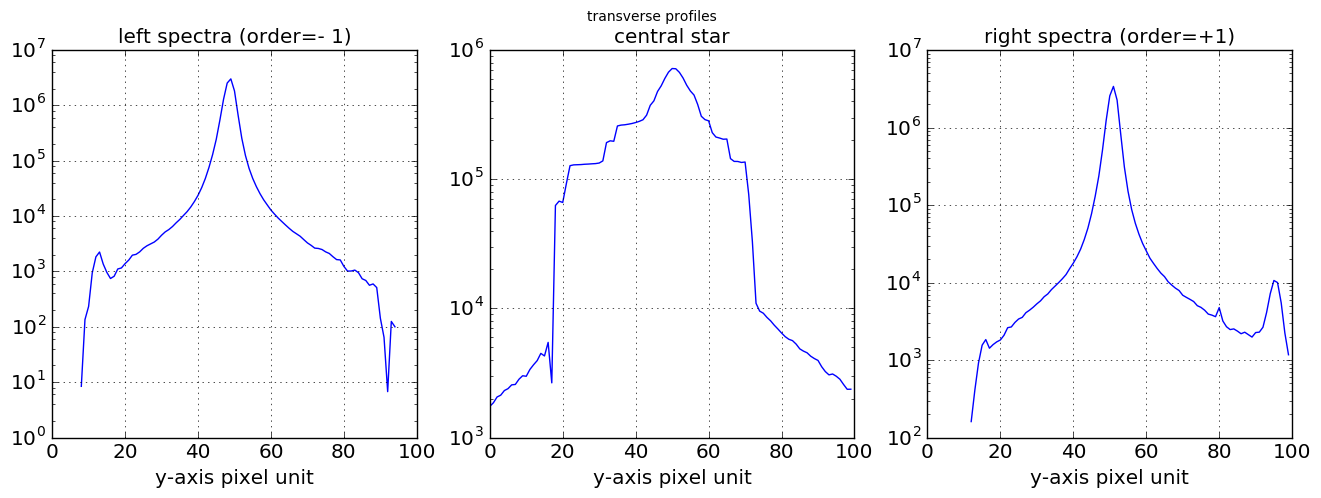

In [44]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16.,5))
ax1.semilogy(profile1[imax-5*w:imax+5*w])
ax2.semilogy(profile2[imax-5*w:imax+5*w])
ax3.semilogy(profile3[imax-5*w:imax+5*w])
#ax1.plot(profile1)
#ax2.plot(profile2)
#ax3.plot(profile3)
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)

ax1.set_title('left spectra (order=- 1)')
ax2.set_title('central star')
ax3.set_title('right spectra (order=+1)')
ax1.set_xlabel('y-axis pixel unit')
ax2.set_xlabel('y-axis pixel unit')
ax3.set_xlabel('y-axis pixel unit')
plt.suptitle('transverse profiles')

#### Extraction of spectrum region
------------------------------


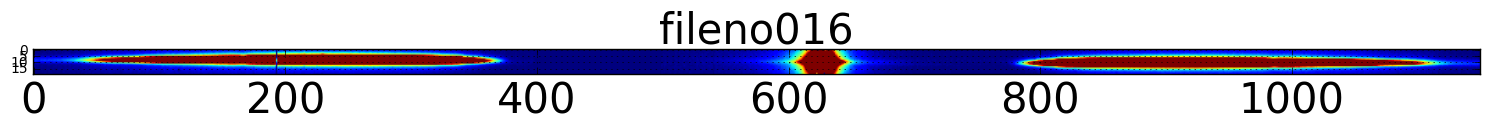

In [45]:
fig, ax = plt.subplots(figsize=(15, 10))
spectraregion=np.copy(rotated_image[imax-w:imax+w,650:1800])
spectraregionav=spectraregion/(2*w)
ax.imshow(spectraregionav,vmin=0,vmax=50.)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=10)
ax.grid(True)
plt.title(object_name,fontsize=30)
plt.tight_layout()

### Spectrum
==============

In [46]:
spectrum=np.sum(spectraregionav,axis=0)

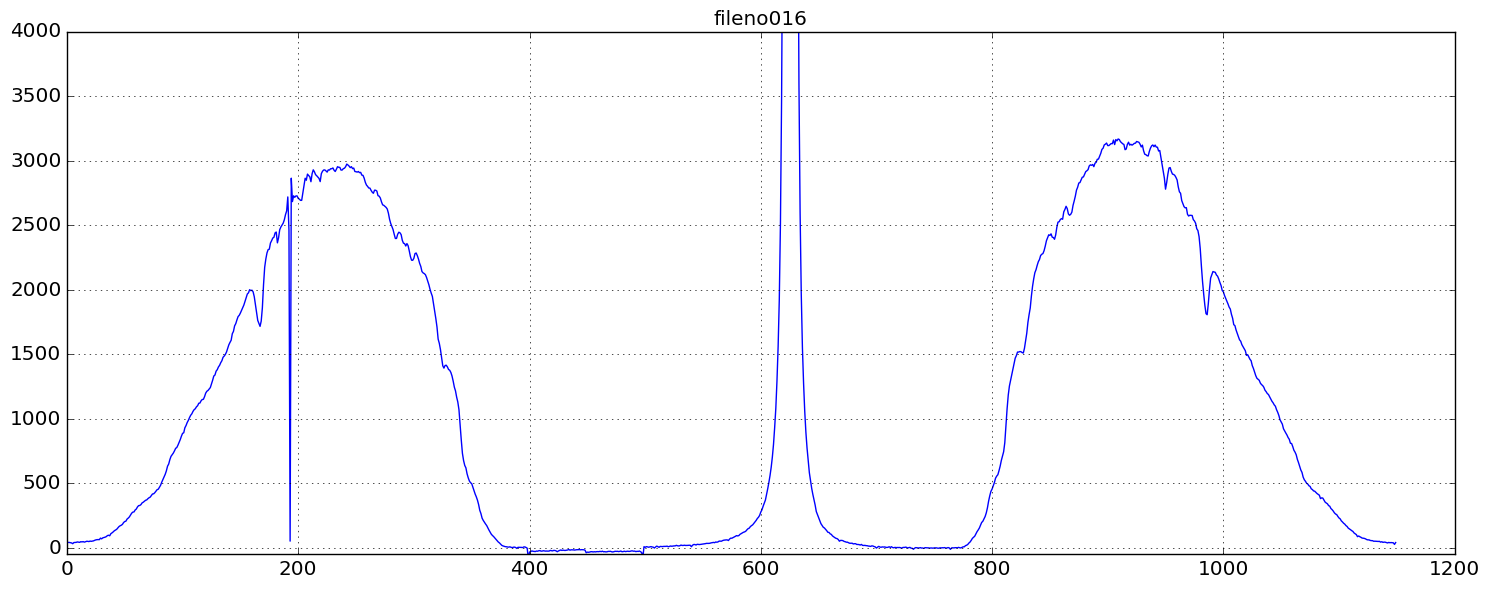

In [47]:
fig, ax = plt.subplots(figsize=(15, 6))
#plt.semilogy(spectrum)
plt.plot(spectrum)
plt.ylim(-50.,4000.)
plt.title(object_name)
plt.tight_layout()
#plt.xlim(0.,1000.)
plt.grid(True)
#plt.savefig(outputfigfilename6)
